In [1]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
import os
import matplotlib.colors as mcolors


# ================================================
# 1) Carregar o dataset salvo
# ================================================
dataset_filename = "dataset_with_weights.pt"

try:
    loaded_data = torch.load(dataset_filename, map_location=torch.device('cpu'), weights_only=False)
    graphs_by_exam = loaded_data["grafos"]
    print(f"\nDataset '{dataset_filename}' carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")
    exit()

# ================================================
# 2) Verificar a Estrutura do Dataset
# ================================================
exam_keys = list(graphs_by_exam.keys())

print("\n========================= INFORMAÇÕES DO DATASET =========================")
print(f"Total de exames no dataset: {len(exam_keys)}")

# Pegamos um exemplo para inspecionar
exam_id = exam_keys[0]
exam_data = graphs_by_exam[exam_id]

grafo = exam_data["grafo"]
label = exam_data["label"]

# Verificando as formas dos arrays e atributos do grafo
print(f"\nExam ID: {exam_id}")
print(f"Label: {label}")
print(f"Formato de x (features dos nós): {grafo.x.shape}")
print(f"Formato de edge_index (arestas): {grafo.edge_index.shape}")
print(f"Formato de edge_attr (pesos das arestas): {grafo.edge_attr.shape}")

# Contar grafos vazios (sem conexões)
empty_graphs = sum(1 for g in graphs_by_exam.values() if g["grafo"].edge_index.shape[1] == 0)
print(f"\nQuantidade de grafos vazios (sem arestas): {empty_graphs}/{len(exam_keys)}")



Dataset 'dataset_with_weights.pt' carregado com sucesso!

========================= INFORMAÇÕES DO DATASET =========================
Total de exames no dataset: 25

Exam ID: 1169160
Label: [0 0 0 0 0 0]
Formato de x (features dos nós): torch.Size([1000, 48])
Formato de edge_index (arestas): torch.Size([2, 8960])
Formato de edge_attr (pesos das arestas): torch.Size([8960])

Quantidade de grafos vazios (sem arestas): 0/25


Grafo do exam_id 271011 criado com 1000 nós e 17698 arestas.


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

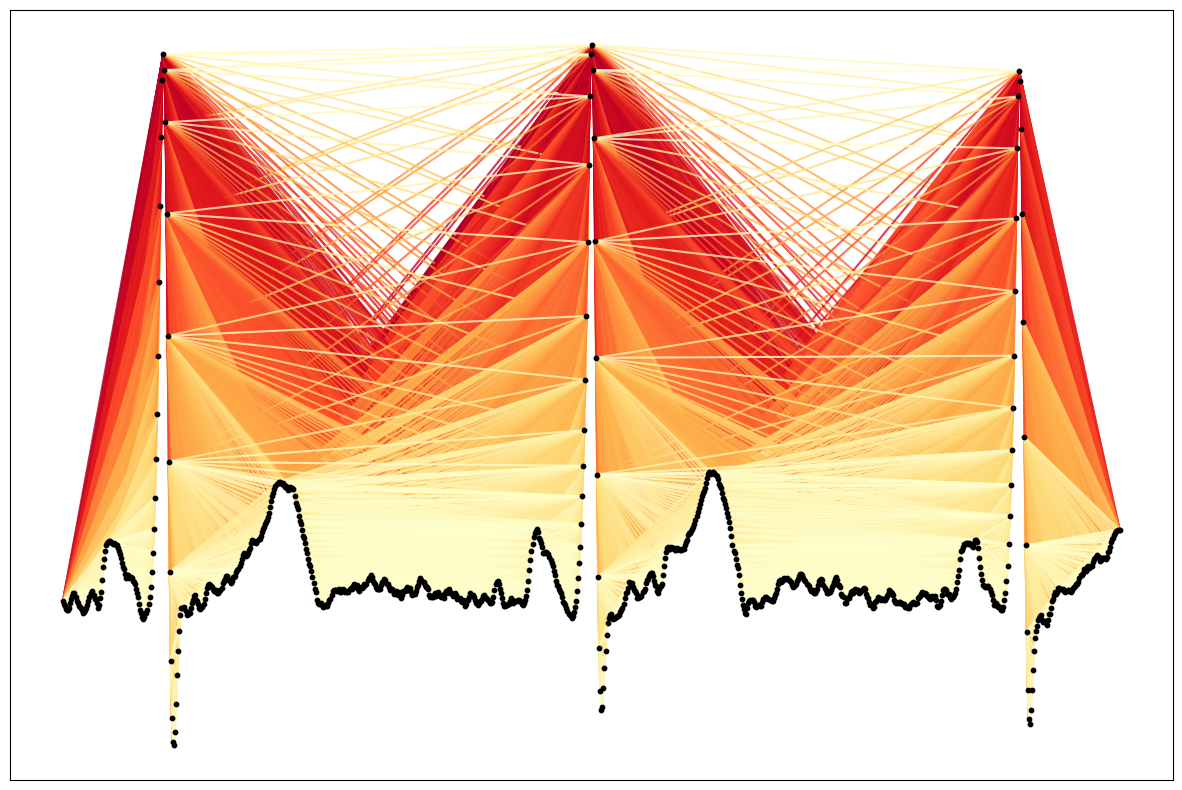

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.colors as mcolors

def visualizar_grafo_com_matplotlib(pt_path, exam_id):
    """
    Carrega o arquivo .pt contendo os grafos processados (com chave "grafo" e "label")
    e visualiza o grafo de um ECG específico para um dado exam_id, usando Matplotlib.
    Nesta visualização:
      - Os nós são posicionados pelo índice e pela 4ª feature (pagerank).
      - As arestas são coloridas conforme seus pesos armazenados no dataset (edge_attr).
    
    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        exam_id (str/int): O ID do exame.
    """
    try:
        dados_salvos = torch.load(pt_path, map_location=torch.device('cpu'), weights_only=False)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado nos dados salvos.")
        return

    exam_dict = grafos_by_exam[exam_id]
    label = exam_dict.get("label", "Sem Label")
    graph_data = exam_dict.get("grafo")
    if graph_data is None:
        print(f"Grafo não encontrado para o exame {exam_id}.")
        return

    edge_index = graph_data.edge_index  # Tensor de shape [2, num_edges]
    edge_attr = graph_data.edge_attr.cpu().numpy() if graph_data.edge_attr is not None else None
    node_features = graph_data.x  # Tensor de shape [num_nodes, 48]

    # Usa a 4ª feature (pagerank) para definir a posição dos nós no eixo Y
    node_positions = node_features[:, 4].cpu().numpy()
    edges = edge_index.cpu().numpy()

    num_nodes = len(node_positions)
    if edges.size > 0:
        max_node = int(max(np.max(edges[0]), np.max(edges[1])))
        if max_node >= num_nodes:
            print("Atenção: O vetor de posições não cobre todos os nós do grafo.")
            num_nodes = max_node + 1

    # Criar o grafo com NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))

    print(f"Grafo do exam_id {exam_id} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Define as posições: x = índice do nó, y = pagerank
    pos = {i: (i, node_positions[i]) for i in range(len(node_positions))}

    # **Normaliza os pesos das arestas para mapeamento de cores**
    if edge_attr is not None and len(edge_attr) > 0:
        vmin, vmax = min(edge_attr), max(edge_attr)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.cm.YlOrRd  # **Amarelo → Vermelho**
        edge_colors = [cmap(norm(weight)) for weight in edge_attr]
    else:
        edge_colors = "gray"  # **Caso sem pesos**

    # **Plotagem**
    plt.figure(figsize=(15, 10))
    
    # **Desenha arestas com cores proporcional ao peso**
    edge_list = list(zip(edges[0], edges[1]))
    for i, (u, v) in enumerate(edge_list):
        if edge_attr is not None:
            color = cmap(norm(edge_attr[i]))
        else:
            color = "gray"
        plt.plot(
            [pos[u][0], pos[v][0]],  # X-coord
            [pos[u][1], pos[v][1]],  # Y-coord
            color=color, alpha=0.8, lw=1.5
        )

    # **Desenha nós**
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='black')

    # **Adiciona barra de cores para os pesos das arestas**
    if edge_attr is not None and len(edge_attr) > 0:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, fraction=0.03, pad=0.02)
        cbar.set_label("Peso das Arestas")

    plt.title(f"Visualização do Grafo\nExam ID: {exam_id} | Label: {label}")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Pagerank (4ª Feature)")
    plt.grid(True)
    plt.show()

# **Defina o caminho do dataset**
pt_path = "dataset_with_weights.pt"

# **Defina o exam_id que deseja visualizar**
exam_id = 271011  # Exemplo: utilize um exam_id presente em seus dados

# **Visualiza o grafo com as arestas coloridas pelo peso**
visualizar_grafo_com_matplotlib(pt_path, exam_id)
